In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import torch.cuda 


import torchvision #數據庫

import matplotlib.pyplot as plt

import os

torch.manual_seed(1)
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")


  

config = {
    "epoch":5,
    "batch_size":50,
    "LR":0.001,
    "DOWNLOAD_MNIST": False if os.path.exists('./mnist') else True
}


train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(), # 值 0 ～ 1 
    download=config["DOWNLOAD_MNIST"]
)

In [2]:
torch.cuda.current_device()


0

In [3]:
# Picture size

train_data.train_data.size(),train_data.train_labels.size()

(torch.Size([60000, 28, 28]), torch.Size([60000]))

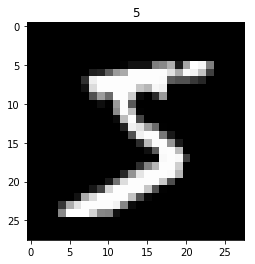

In [4]:
# show Picture

plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
# 載入 data loader

data_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2
)

In [6]:
test_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=False,
)

In [7]:
test_data.test_data.size()

torch.Size([10000, 28, 28])

In [8]:
# 加 batch_size 維度
# shape from (10000, 28, 28) to (10000, 1, 28, 28)
# 一筆資料 (1,28,28)

test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)
# value in range(0,1)
test_x /= 255. # normalize

test_y = test_data.test_labels

test_x.size(),test_y.size()

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [9]:
# CNN model 

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # 一個 conv_layer
        self.conv_layer1 = nn.Sequential(
            # 2d掃描器,區域提取訊息特徵
            nn.Conv2d(
                in_channels = 1, #高度 像 RGB 有 3 個
                out_channels = 16, # 16個 filter 同時掃描
                kernel_size = 5, # 每個 filter的長寬
                stride = 1, # filter 一次走得步數
                
                padding = 2, #讓 data 補足 padding = (kernel_size-1)/2
            ),   # -> (16,28,28)
            nn.ReLU(), # -> # (16,28,28)
            nn.MaxPool2d(kernel_size=2), #篩選重要資訊 取最大
                                         # -> (16,14,14)
        )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding = 2
            ), # -> (32,14,14)
            
            nn.ReLU(), # -> (32,14,14)
            
            nn.MaxPool2d(kernel_size=2) #  -> (32,7,7)
        )
        
        self.output_layer = nn.Linear(
            in_features=32*7*7,  #  (32,7,7) -> (32*7*7)
            out_features=10
        )
        
    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)  #->(batch,32,7,7)
        
        x = x.view(x.size(0),-1) # 壓縮 data (batch,32,7,7) ->(batch,32*7*7)
        
        
        
        return self.output_layer(x)  # 使用 nn.CrossEntropyLoss 不需要加 softmax
                                     # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
        
        
        

In [10]:
# Create Model
        
model = CNN().to(device) if torch.cuda.is_available() else CNN()

print(model)

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Linear(in_features=1568, out_features=10, bias=True)
)


In [11]:
def draw_loss(loss_history):
    
    plt.plot(loss_history,label="loss",linewidth=1)
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, 4))
    plt.show()


def train(model):
    l_h = []
    
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(),lr=config['LR'])
    loss_fun = nn.CrossEntropyLoss()
    
    for epoch in range(config['epoch']):
        for step,(b_x,b_y) in enumerate(data_loader):
            
            b_x,b_y = b_x.to(device), b_y.to(device)
            optimizer.zero_grad()      
            
            output = model(b_x)
            
            loss = loss_fun(output,b_y)
            
            
            
            loss.backward()
            optimizer.step()
            
            l_h.append(loss.item()) # item() get a Python number from a tensor containing a single value
                                    # print(loss.item(),loss.detach())
                                    # 0.000888 tensor(0.0009, device='cuda:0')

            if step % 200 == 0:
                
                print('Epoch: ', epoch, '| step ',step,'| train loss: %.4f' % loss.item())
                
                
            
    
    
    draw_loss(l_h)
    

In [12]:
torch.cuda.is_available()

True

Epoch:  0 | step  0 | train loss: 2.3105
Epoch:  0 | step  200 | train loss: 0.4053
Epoch:  0 | step  400 | train loss: 0.1236
Epoch:  0 | step  600 | train loss: 0.0239
Epoch:  0 | step  800 | train loss: 0.0435
Epoch:  0 | step  1000 | train loss: 0.0329
Epoch:  1 | step  0 | train loss: 0.0200
Epoch:  1 | step  200 | train loss: 0.0136
Epoch:  1 | step  400 | train loss: 0.2024
Epoch:  1 | step  600 | train loss: 0.0604
Epoch:  1 | step  800 | train loss: 0.0018
Epoch:  1 | step  1000 | train loss: 0.0026
Epoch:  2 | step  0 | train loss: 0.0378
Epoch:  2 | step  200 | train loss: 0.0175
Epoch:  2 | step  400 | train loss: 0.0336
Epoch:  2 | step  600 | train loss: 0.0023
Epoch:  2 | step  800 | train loss: 0.1825
Epoch:  2 | step  1000 | train loss: 0.0370
Epoch:  3 | step  0 | train loss: 0.0390
Epoch:  3 | step  200 | train loss: 0.0484
Epoch:  3 | step  400 | train loss: 0.0057
Epoch:  3 | step  600 | train loss: 0.0471
Epoch:  3 | step  800 | train loss: 0.0035
Epoch:  3 | step

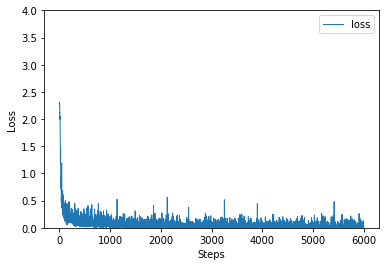

In [13]:
train(model)

In [14]:
def test(model,test_x,test_y):
    model.eval()
    
    with torch.no_grad():
        test_x,test_y = test_x.to(device),test_y.to(device)                                                   
        output = model(test_x)
        predit = torch.max(output, 1)[1]
        accuracy = torch.sum(predit==test_y).type(torch.FloatTensor)/test_y.size(0)
        
        print(accuracy.item())
    

In [15]:
test(model,test_x,test_y)

0.9883000254631042
